# Part 6 - Feature Matching

- We've already seen template matching to find objects within a large image, but it required an exact copy of the image.
- Often that isn't useful in a real world situation!
- Feature matching extracts defining key features from an input image (using ideas from corner, edge and contour detection).
- Then using a distance calculation, finds all the matches in a secondary image.
- This means we are no longer required to have an exact copy of the target image!

![Example](https://docs.opencv.org/4.x/matcher_result1.jpg)

- Notice how the input image is not exaqctly what is shown in the secondary image!
- **We will check out 3 methods:**
    - Brute-Force Matching with ORB Descriptors
    - Brute-Force Matching with SIFT Descriptors and Ratio Test
    - FLANN based Matcher
- We will be testing a generic cereal image and seeing if we can find its matching box in the cereal side.

In [1]:
import os
import sys

current_dir = os.path.abspath("")
parent_dir  = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from utilities import show_img

import numpy as np
import matplotlib.pyplot as plt

import cv2

## `Brute-Force Matching with ORB Descriptors`

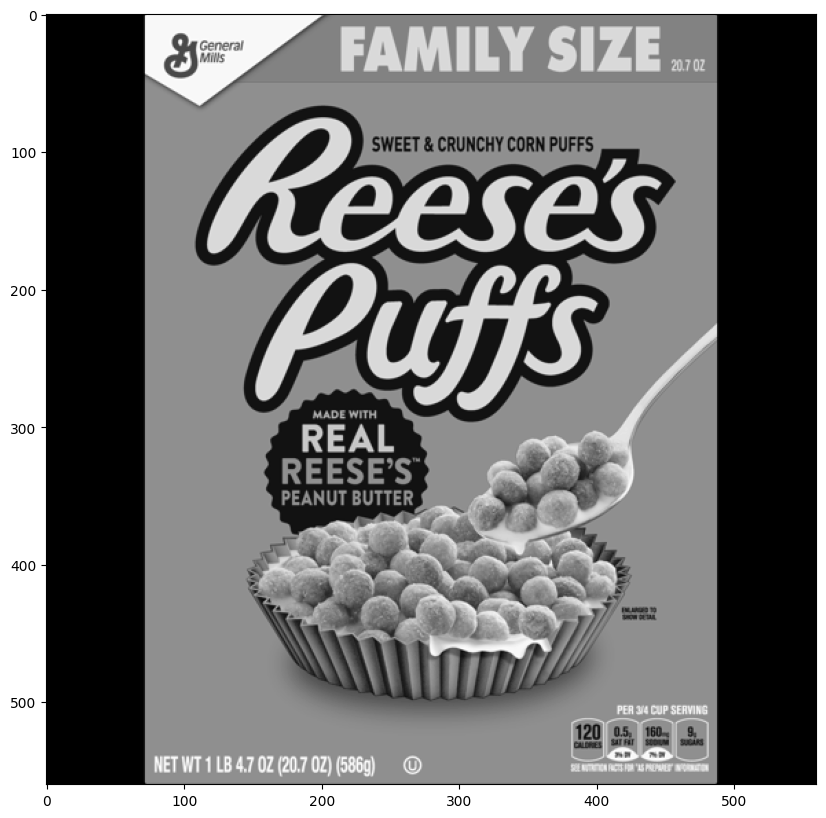

In [2]:
reeses = cv2.imread("../DATA/reeses_puffs.png", cv2.IMREAD_GRAYSCALE)

show_img(reeses, figsize=(12, 10))

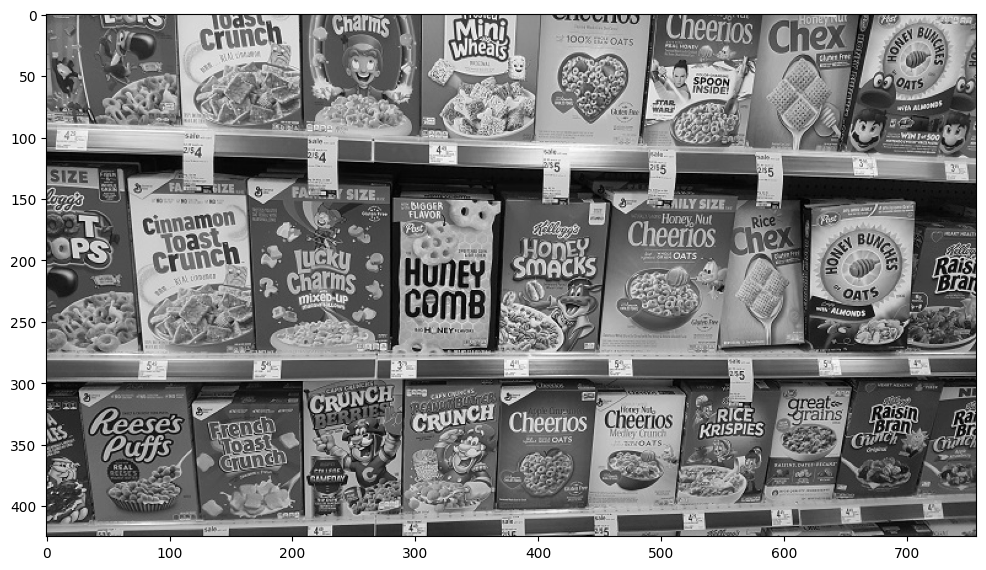

In [3]:
cereals = cv2.imread("../DATA/many_cereals.jpg", cv2.IMREAD_GRAYSCALE)

show_img(cereals, figsize=(12, 10))

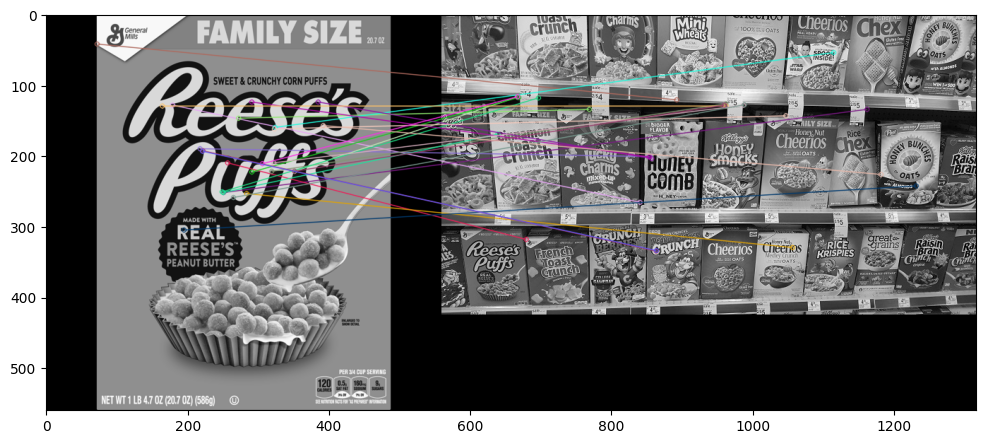

In [4]:
# detector object
orb = cv2.ORB_create()

# kp1=key points, des1=descriptors
kp1, des1 = orb.detectAndCompute(reeses, mask=None)
kp2, des2 = orb.detectAndCompute(cereals, mask=None)

# Brute-Force Matching time
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# find the matches
matches = bf.match(des1, des2)

# short based on the distance, this distance tells how good this match is
matches = sorted(matches, key=lambda x: x.distance)

reeses_matches = cv2.drawMatches(
    img1=reeses,
    keypoints1=kp1,
    img2=cereals,
    keypoints2=kp2,
    matches1to2=matches[:25],
    outImg=None,
    flags=2
)

show_img(reeses_matches, figsize=(12, 10))

## `Brute-Force Matching with SIFT Descriptors and Ratio Test`

We found 79 good matches among 1501 matches!


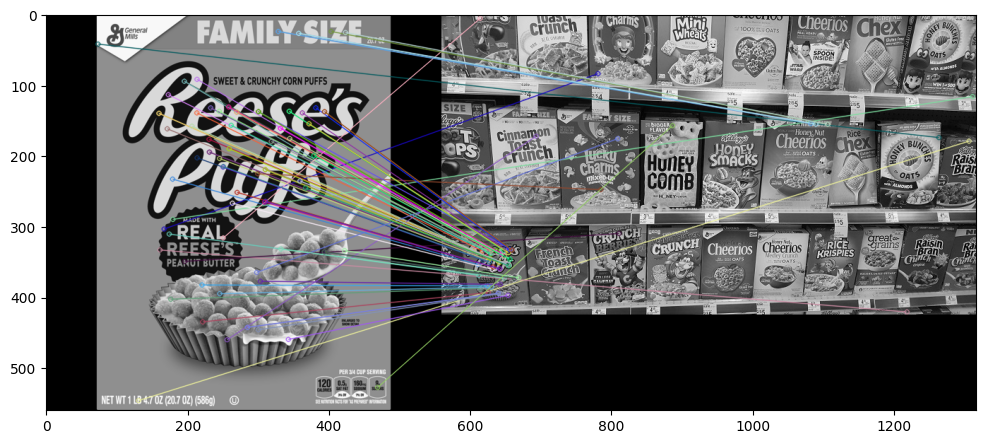

In [10]:
sift = cv2.xfeatures2d.SIFT_create()  ## different

kp1, des1 = sift.detectAndCompute(reeses, mask=None)
kp2, des2 = sift.detectAndCompute(cereals, mask=None)

bf = cv2.BFMatcher()

matches = bf.knnMatch(queryDescriptors=des1, trainDescriptors=des2, k=2)  ## different

# ratio test time: ratio match1 < 75% of match2
# less distance means a better match
good = []
for match1, match2 in matches:
    
    # if match1 distance is less than 75% of match2 distance
    # then descriptor was a good match, lets keep it!
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
        
print(f"We found {len(good)} good matches among {len(matches)} matches!")

shift_matches = cv2.drawMatchesKnn(
    img1=reeses,
    keypoints1=kp1,
    img2=cereals,
    keypoints2=kp2,
    matches1to2=good,
    outImg=None,
    flags=2
)

show_img(shift_matches, figsize=(12, 10))

## `FLANN based Matcher`:

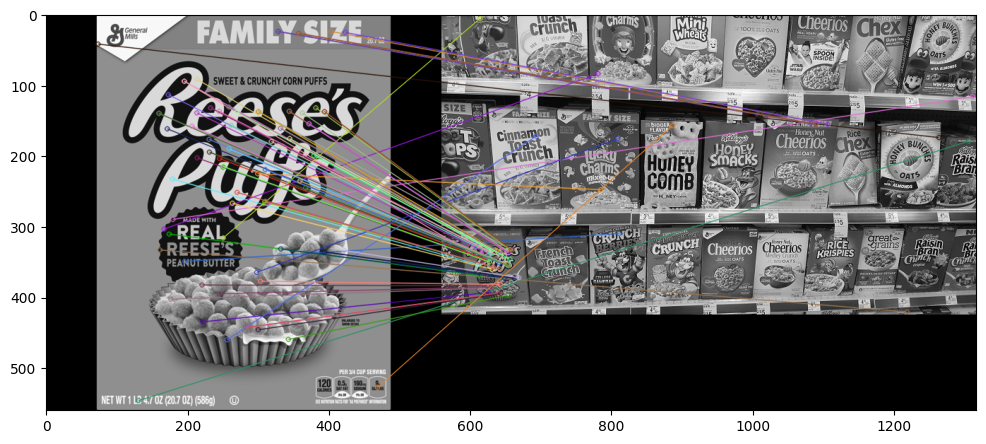

In [15]:
shift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(reeses, mask=None)
kp2, des2 = sift.detectAndCompute(cereals, mask=None)

# FLANN - it finds the good matches but not necessary that would be best
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(queryDescriptors=des1, trainDescriptors=des2, k=2)

good = []
for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good.append([match1])
        
flann_matches = cv2.drawMatchesKnn(
    img1=reeses,
    keypoints1=kp1, 
    img2=cereals, 
    keypoints2=kp2,
    matches1to2=good, 
    outImg=None, 
    flags=0
)

show_img(flann_matches, figsize = (12, 10))

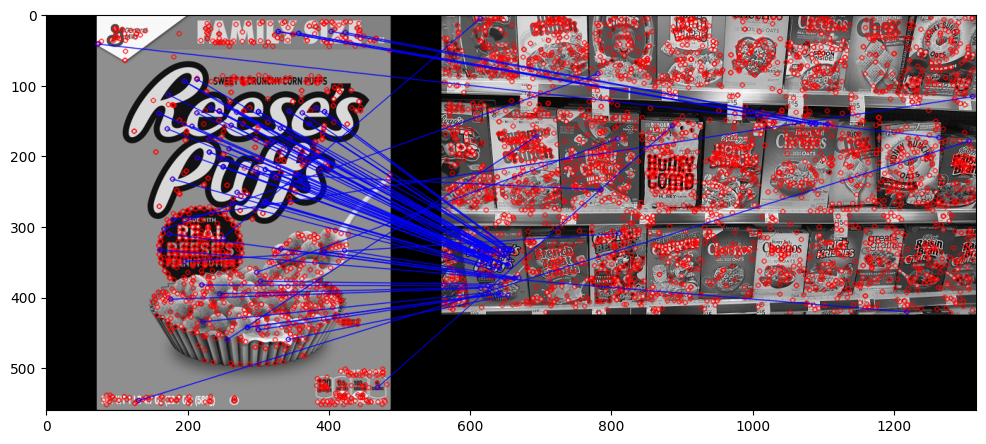

In [17]:
shift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(reeses, mask=None)
kp2, des2 = sift.detectAndCompute(cereals, mask=None)

# FLANN - it finds the good matches but not necessary that would be best
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(queryDescriptors=des1, trainDescriptors=des2, k=2)
matchesMask = [[0, 0] for i in range(len(matches))]

for i, (match1, match2) in enumerate( matches ):
    if match1.distance < 0.75 * match2.distance:
        matchesMask[i] = [1, 0]
        
        
draw_params = dict(
    matchColor = (0, 0, 255),
    singlePointColor = (255, 0, 0),
    matchesMask = matchesMask,
    flags = 0,
)
        
flann_matches = cv2.drawMatchesKnn(
    img1 = reeses,
    keypoints1 = kp1, 
    img2 = cereals, 
    keypoints2 = kp2,
    matches1to2 = matches, 
    outImg = None, 
    **draw_params
)

show_img(flann_matches, figsize = (12, 10))